In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn.cluster import KMeans
from importlib import reload

import utils
import hhclustering as hc
reload(utils)
reload(hc)

<module 'hhclustering' from 'C:\\Users\\jungyoung\\Desktop\\Project\\hh_neuralnet\\three_pop_mpi\\clustering\\hhclustering.py'>

# Load data 

In [2]:
# load data
with open("./data/purified_data.pkl", "rb") as fp:
    buf = pkl.load(fp)
data = buf["data"]
row_labels = buf["row_labels"]
row_names = buf["row_names"]
col_names = buf["col_names"]

# load clustering data
with open("./data/clustering_result.pkl", "rb") as fp:
    tmp = pkl.load(fp)

km_obj_set = tmp["km_obj"]
s_vals = tmp["s_vals"]
s_scores = tmp["s_scores"]
num_clusters = tmp["num_clusters"]

In [3]:
# use nc = 0 case
nc = 9

nK = num_clusters[nc]
cluster_id = km_obj_set[nc].predict(data.T)

# denoise & reorder the clusters 

In [38]:
reload(hc)
rcluster_id = hc.realign_cluster(cluster_id, col_names, num_r=2, num_w=7, ld=15, denoise=True)

# recalculate silhouette value
rsval, rscoeff = hc.get_silhouette_scores(data, rcluster_id)

with open("./data/rcluster.pkl", "wb") as fp:
    pkl.dump({"rcluster_id": rcluster_id,
              "rsval": rsval,
              "rscoeff": rscoeff,
              "K": nK}, fp)

## Draw stack images

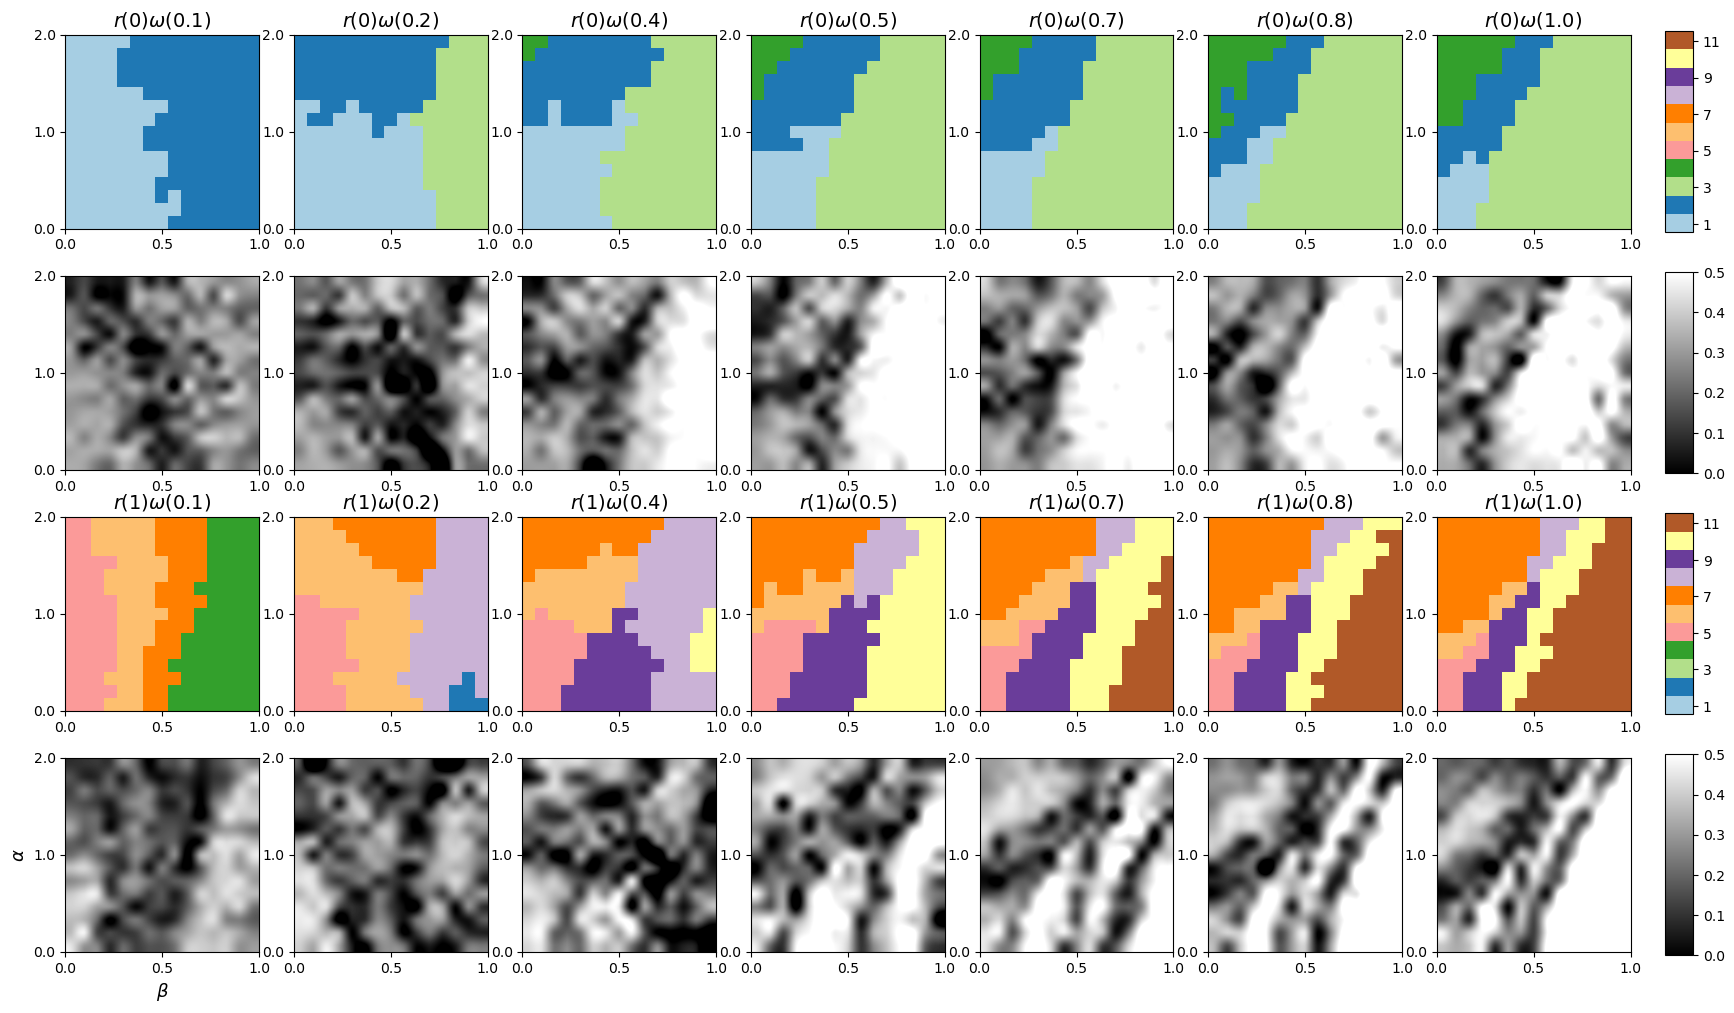

In [69]:
w = np.arange(0.1, 1.01, 0.15)
im_stacks = []

def set_label():
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1], labels=["0.0", "1.0", "2.0"])
        

# plt.figure(dpi=100, figsize=(20, 12))
fig, axs = plt.subplots(4, 8, dpi=100, figsize=(21, 12), gridspec_kw={"width_ratios": [0.98/7 for _ in range(7)] + [0.02]})
caxs = [[], []]
# cmap = plt.get_cmap("jet", nK)
cmap = plt.get_cmap("Paired", nK)

for nr in range(2):
    im_stacks.append([])
    for nw in range(7):
        im, _ = hc.construct_square_image("nr%dnp%d"%(nr, nw), rcluster_id, col_names)
        im_sval, _ = hc.construct_square_image("nr%dnp%d"%(nr, nw), rsval, col_names)
        im_stacks[-1].append(im)
        
        plt.axes(axs[2*nr, nw])
        caxs[0] = plt.imshow(im, vmin=1, vmax=nK, origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
        plt.title(r"$r(%d)\omega(%.1f)$"%(nr, w[nw]), fontsize=14)
        set_label()
        
        plt.axes(axs[2*nr+1, nw])
        caxs[1] = plt.imshow(im_sval, vmin=0, vmax=0.5, origin="lower", extent=[0, 1, 0, 1], cmap="gray", interpolation="spline16")
        set_label()

        if nr == 1 and nw == 0:
            plt.xlabel(r"$\beta$", fontsize=13)
            plt.ylabel(r"$\alpha$", fontsize=13)
            
            
for n in range(4):
    plt.axes(axs[n][7])
    cbar = plt.colorbar(caxs[n%2], cax=axs[n][7])
    if n%2 == 0:
        ct = np.arange(1, nK+1, 2).astype(int)
        ct_x = 0.5 + ct / nK * (nK-1)
        cbar.set_ticks(ct_x, labels=["%d"%(n) for n in ct])

# utils.save_fig("ordered_cluster_id")
# with open("./data/im_stacks.pkl", "wb") as fp:
#     pkl.dump({"im_stacks": im_stacks,
#               "rcluster_id": rcluster_id}, fp)

plt.show()

## Check similarity 

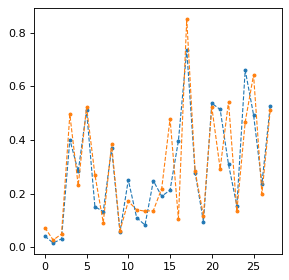

save to ./data\similarity_2023625.png


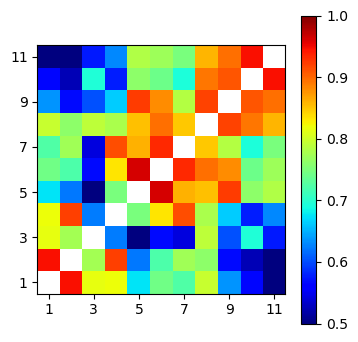

v01-v02 pair similarity exceeds 0.9, actual value = 0.945
v02-v04 pair similarity exceeds 0.9, actual value = 0.920
v04-v07 pair similarity exceeds 0.9, actual value = 0.913
v05-v06 pair similarity exceeds 0.9, actual value = 0.961
v05-v09 pair similarity exceeds 0.9, actual value = 0.924
v06-v07 pair similarity exceeds 0.9, actual value = 0.932
v08-v09 pair similarity exceeds 0.9, actual value = 0.918
v09-v10 pair similarity exceeds 0.9, actual value = 0.909
v10-v11 pair similarity exceeds 0.9, actual value = 0.946


In [212]:
reload(hc)

def norm2(vec):
    return np.sqrt(vec @ vec.T)

# extract average values
prods_avg, prods_std = hc.extract_mean_val(data, rcluster_id-1)

# plot
plt.figure(dpi=80, figsize=(4, 4))
plt.plot(prods_avg[:, :2], '.--', ms=5, lw=1)
plt.show()

# get similarity
mat_sim = np.zeros([nK, nK])
for i in range(nK):
    v0 = prods_avg[:, i]
    v0 /= norm2(v0)
    for j in range(i+1, nK):
        v1 = prods_avg[:, j]
        v1 /= norm2(v1)
        mat_sim[i, j] = v0 @ v1.T
        mat_sim[j, i] = mat_sim[i, j]
    mat_sim[i, i] = np.nan
        
plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(mat_sim, cmap="jet", vmin=0.5, vmax=1)
xt, _ = plt.xticks()
lb = ["%d"%(n+1) for n in xt]
plt.xticks(xt, labels=lb)
plt.yticks(xt, labels=lb)
plt.xlim([-0.5, nK-0.5])
plt.ylim([-0.5, nK-0.5])
# plt.xticks(
plt.colorbar()
utils.save_fig("similarity")
plt.show()

# notice of high similarity pairs
th_sim = 0.9
for i in range(nK):
    for j in range(i+1, nK):
        if mat_sim[i, j] > th_sim:
            print("v%02d-v%02d pair similarity exceeds %.1f, actual value = %.3f"%(i+1, j+1, th_sim, mat_sim[i, j]))

## Visualize flatten image 

In [215]:
# Visualize image
align_data, id_sort, bds = hc.reorder_data(data, rcluster_id, sval=rsval)

In [ ]:
s_data = hc.hsmooth(align_data, wsize=10, fo=2)

plt.figure(figsize=(6, 8))
plt.imshow(s_data, aspect="auto", cmap="jet", interpolation="none")

bds0 = [0] + bds
for n in range(len(bds0)-1):
    x = (bds0[n] + bds0[n+1])/2
    plt.text(x, -0.8, "%d"%(n+1), fontsize=12, ha="center")
plt.text(-150, -0.8, "cid", fontsize=12, ha="center")
    
yl = plt.ylim()
for b in [0]+bds:
    plt.plot([b, b], yl, 'k--', lw=1)
plt.ylim(yl)
plt.xlim([0, s_data.shape[1]])

plt.xlabel("point", fontsize=14)
plt.ylabel("features", fontsize=14)
plt.yticks(np.arange(0, len(row_names), 1), labels=row_labels[::1])

plt.tight_layout()
utils.save_fig("aligned_features")

plt.show()

##  show feature

In [4]:
with open("./data/im_stacks.pkl", "rb") as fp:
    tmp = pkl.load(fp)

rcluster_id = tmp["rcluster_id"]
im_stacks = tmp["im_stacks"]

prods_avg, prods_std = hc.extract_mean_val(data, rcluster_id)

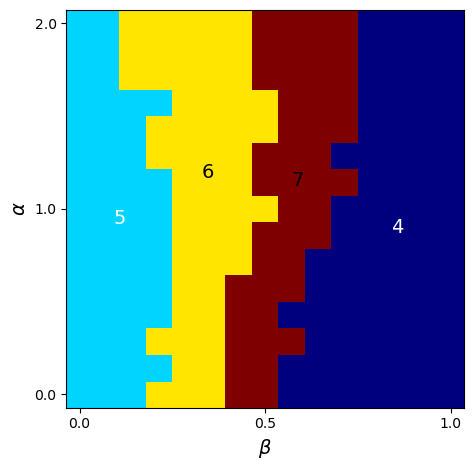

In [44]:
id_r, id_p = 1, 0

plt.figure()
hc.show_sq_cluster(im_stacks[id_r][id_p], cmap="jet", cth=None)
plt.xticks([0, 7, 14], labels=["%.1f"%(x) for x in [0, 0.5, 1]])
plt.yticks([0, 7, 14], labels=["%.1f"%(x) for x in [0, 1, 2]])
plt.ylabel(r"$\alpha$", fontsize=14)
plt.xlabel(r"$\beta$", fontsize=14)
plt.tight_layout()
plt.show()

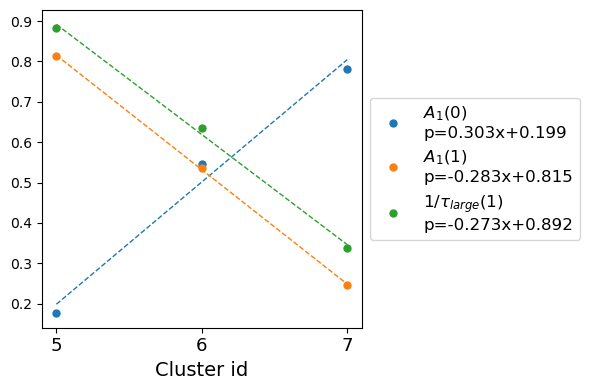

In [45]:
reload(hc)

plt.figure(figsize=(6, 4))
models = hc.regress_differ([5, 6, 7], prods_avg, row_labels, nshow=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.xticks(fontsize=13)
plt.tight_layout()
plt.show()

### Show representative images

In [ ]:
d

In [ ]:
cid = 1

case = "best" # best, intermediate, worst
nshow = 2




In [ ]:
# Show 